In [22]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import nltk, string, random, numpy, os
import matplotlib.pyplot as plt
from typing import List
os.makedirs('./results', exist_ok=True)
nltk.download('brown')
random.seed(42)
torch.manual_seed(42)
numpy.random.seed(42)
import numpy as np

[nltk_data] Downloading package brown to
[nltk_data]     /Users/christophlaute/nltk_data...
[nltk_data]   Package brown is already up-to-date!


### Introduction
In the warm-up of this assignment, we will see how Neural Networks (NN) handle natural language data.   
The warm-up focuses on a simple Multilayer Perceptron (MLP), also known as a fully connected Neural Network. The data we'll use is the first 5000 unique words of the Brown corpus.

### Dataset
To train the model, we will have to represent the input words to the model in some way. Since models solely work with numbers, the words will have to be converted into numerical form.  
For this assignment, we will focus on predicting individual words from the dataset given the input of the model. The input will be the target word split up into individual letters. To represent these individual letters we will give the model a vector of 26 positions (26 letters in the English alphabet). Initially, this vector is filled with zeros and for every occuring letter in the word we change the value to 1 in that position. For instance, in the word `apple', we have 1 a, 1 e, 1 l and 2 p. The vector will then represent the word as:  
```[1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0]```  
You will have to implement this algorithm together with loading the Brown dataset and taking the first 5000 unique words. Implement a way to store the indexes of the unique words as a dictionary where the word is the key and the index is the value as well as the target list (which will be just the indexes of the words).

In [ ]:
class AlphaDataset(Dataset):
    def __init__(self) -> None:
        # Load the NLTK Brown corpus and store the first 5000 unique words of the corpus in self.data
        self.data = []
        for word in nltk.corpus.brown.words():
            if word not in self.data:
                self.data.append(word)
            if len(self.data) == 5000:
                break
        self.word_to_idx = {word:i for i,word in enumerate(self.data)} # Convert the unique words to an index dictionary {word: index}
        self.targets = [self.word_to_idx[word] for word in self.data] # Make these indexes the target values
        

    def __len__(self) -> int:
        # Torch requires the implementation of the length function to calculate the number of instances in the dataset. Find a way to implement this
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        word = list(x)
        alphabet = list("abcdefghijklmnopqrstuvwxyz")
        alpha_dict = {ch:0 for ch in alphabet}
        for element in word:
            if element.lower() in alpha_dict:
                alpha_dict[element.lower()] += 1
        x = list(alpha_dict.values())
        


        # Apply processing to turn the word (stored in x) into a numeric vector of 26 numbers, counting the occurences of the letters.
        # Example: apple would become [1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0], counting 2 occurences for the letter p and zero for letters that do not occur.

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return x, y
    

### Multilayer Perceptron
In the following section, you will implement a MLP. The goal is to implement this MLP with 1 input layer, 2 hidden layers, and 1 output layer.
With PyTorch, the linear layer is most suitable for this. When you create a linear layer, you define the input and output size of the layer, effectively creating two linear neuron layers. This is useful to know since we only need to create 3 linear layer classes to have the 4 layers we want.
The hidden size is stored as a list where the first value will be 256 and the second value will be 512.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size: int, hidden_size: List[int], output_size: int) -> None:
        super().__init__()
        
        # define layers of neural network 
        self.input_layer = torch.nn.Linear(input_size, hidden_size[0])
        self.hidden_layer = torch.nn.Linear(hidden_size[0], hidden_size[1])
        self.output_layer = torch.nn.Linear(hidden_size[1], output_size)
        # define activation function 
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
       
        # forward_pass
        x = self.input_layer(x)
        x = self.activation(x)
        x = self.hidden_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)

        return x

### Setting up the hyperparameters
These are the hyperparameters used for the model, they define the layout of the model as well as the performance:
- batch_size, defines the number of instances the model sees at one time.
- learning_rate, defines the change rate of the gradient descent.
- input_size, the number of input neurons for the model, the number of letters in the alphabet
- hidden_size, the number of neurons in the hidden layer
- output_size, the number of neurons in the output layer, for us this is the number of unqiue words

In [25]:
batch_size = 8
learning_rate = 1e-5
input_size = 26
hidden_size = [256, 512]
output_size = 5000
device = 'cpu' # If you have an m1 macbook use: 'mbp', if you have an NVIDIA GPU use: 'cuda:0' else leave as is

Setting up the dataset

In [26]:
# Define the dataset and the dataloader
dataset = AlphaDataset()

# For the final evaluation of the model we will use 20% of the data for testing. Testing is only ever done after hyperparameter tuning.
# Split sizes (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# To evaluate our model we want to take 10% of the dataset for validation, this is similar to the testset, rather this data we can use during hyperparameter tuning.
# The validation and test data is never trained on and is unseen data for the model, making it closer to a production setting.
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffling ensures the model does not overfit on ordering of the data.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # This data does not need to be shuffled
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  #T his data does not need to be shuffled

### Preperation for training
Here we load the model into memory, apply it to the selected device and define the optimizer. The optimizer guides the model to the best possible state it can be in through Gradient descent.
Lastly, the loss function is defined, this defines how well the model performs, based on this number the model knows how it should change its weights.

In [27]:
model = MLP(input_size, hidden_size, output_size)
model.to(device) # Tell de model which accelerator to use (Macbook GPU, NVIDIA GPU or CPU)

# In Neural Networks optimizers handle the efficient training through gradient descent, we will use Adam
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# The loss function defines how well the model is performing, if the loss is low the model is rewarded, if it is high the model is punished.
# Since we are dealing with a classification task we will use Cross Entropy
loss_fn = nn.CrossEntropyLoss()

### Training
In the next block the training block is already defined. This is a standard way to train the model for 50 epochs (50 times it will see the dataset). Each time it does one epoch we also go over the validationset.

In [28]:
training_losses = []
validation_losses = []

for epoch in range(50): # Train for 50 epochs
    model.train() # Enforce model training
    for step, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        training_losses.append(loss.item())
        print(loss.item(), end='\r')

        loss.backward() # Calculate gradients

        optimizer.step() # Reward the model
        optimizer.zero_grad() # Clean the gradients
    print('Training_loss:', loss.item())

    model.eval() # After every training epoch we want to see the model's performance on the validation data
    with torch.no_grad(): # In validation we dont need gradients so we tell torch to not calculate them
        total_val_loss = 0
        for step, (x, y) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)

            output = model(x)

            loss = loss_fn(output, y)

            total_val_loss += loss.item()

        validation_losses.append(total_val_loss / len(val_dataset))
        print('Validation_loss:', validation_losses[-1])

Training_loss: 8.547900199890137
Validation_loss: 1.069272587299347
Training_loss: 8.445018768310547
Validation_loss: 1.0796424961090088
Training_loss: 8.333843231201172
Validation_loss: 1.0966825008392334
Training_loss: 8.249979972839355
Validation_loss: 1.1253840661048888
Training_loss: 8.086389541625977
Validation_loss: 1.168041512966156
Training_loss: 7.980297088623047
Validation_loss: 1.2215525555610656
Training_loss: 7.839113712310791
Validation_loss: 1.2805080223083496
Training_loss: 7.582399845123291
Validation_loss: 1.3416649556159974
Training_loss: 7.573844909667969
Validation_loss: 1.4032111167907715
Training_loss: 7.5230207443237305
Validation_loss: 1.4653269910812379
Training_loss: 7.468615531921387
Validation_loss: 1.5286940932273865
Training_loss: 7.232775688171387
Validation_loss: 1.5936280632019042
Training_loss: 7.264202117919922
Validation_loss: 1.6607125210762024
Training_loss: 6.879479885101318
Validation_loss: 1.7309213805198669
Training_loss: 6.849304676055908
Va

### Writing
Below we can print the training statistics, the training loss should be going down while the validation loss should be going up. What does it mean that the validation loss increases?

[Your answer here] Swbas

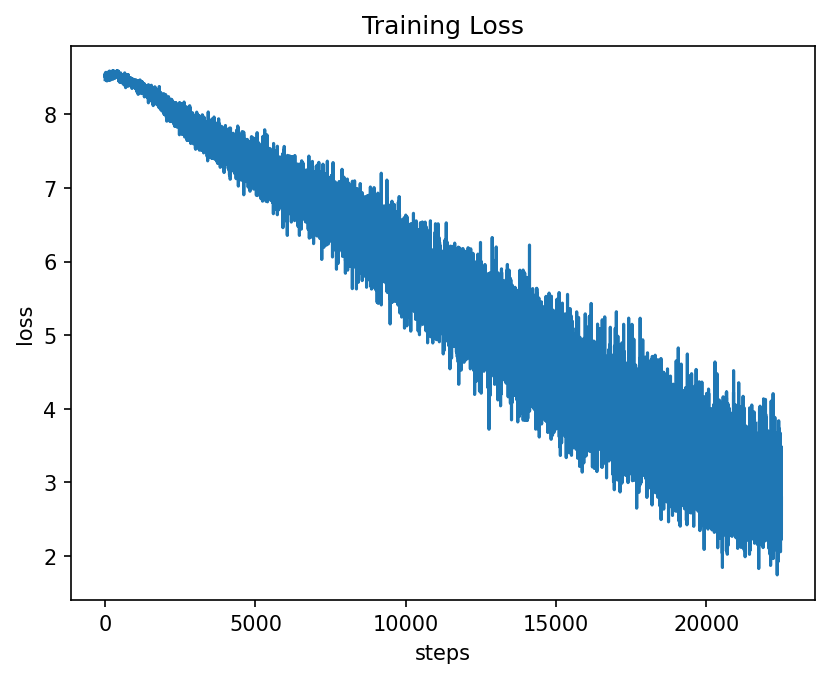

In [29]:
plt.rcParams['figure.dpi'] = 150
plt.plot(training_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Training Loss')
plt.savefig('./results/training_loss.png')

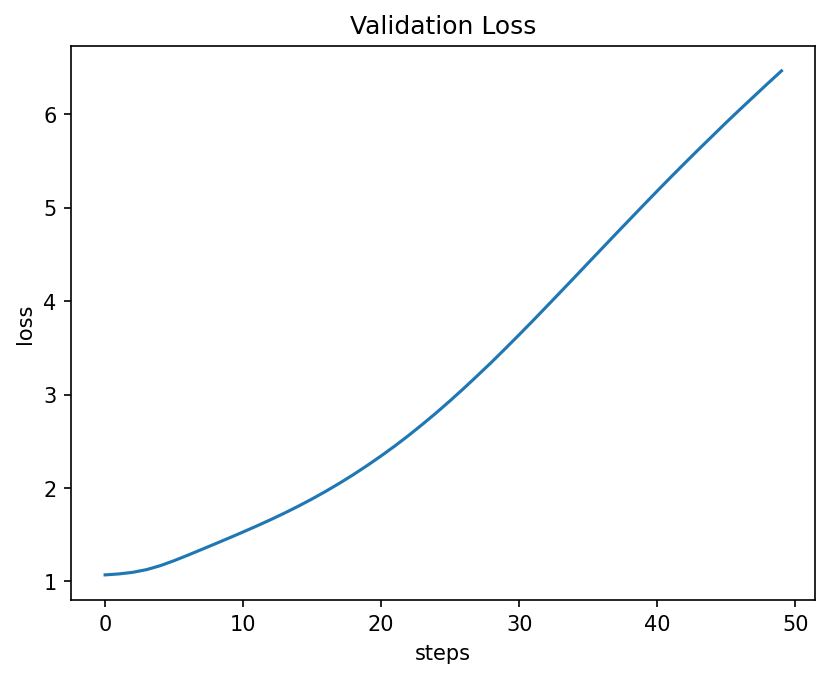

In [30]:
plt.plot(validation_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Validation Loss')
plt.savefig('./results/validation_loss.png')

### Writing
Belowe we want to analyze how the model functions based on the test data. What stands out from these results? Was the result correct? What is the main difference between the words?

Generally it can be observed that the model performed not very good on the data. While it seems to be able to almost predict some words like immediately and league, it still failed to accurately predict those words, either predicting a different case for the word or by using a different word form of the word. With most words it completely fails to predict the correct word, instead predicting a word with a completely different semantic meaning. The model seems to perform especially bad with short words. What stands out in the differences between the words is that although the model fails at predicting the correct word it does seem to correctly predict most letters occuring in a word, since the predicted and observed words share most letters. 

In [31]:
def get_n_words(dataset, n, model, ds, verbose = True):
    if n == -1:
        n = len(dataset)
    x = [dataset.__getitem__(i)[0] for i in range(n)]
    y = [dataset.__getitem__(i)[1] for i in range(n)]
    target_words = [{idx: word for word, idx in ds.word_to_idx.items()}[_.item()] for _ in y]
    out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]
    predicted_words = [{idx: word for word, idx in ds.word_to_idx.items()}[_.item()] for _ in out]
    width = max(len(word) for word in target_words) + 5
    if verbose:
        print('\n'.join([f'target: {t.ljust(width)} predicted: {p}' for t, p in zip(target_words, predicted_words)]))
    return target_words, predicted_words

_,_ = get_n_words(test_dataset, 10, model, dataset)

target: immediately      predicted: immediate
target: drifts           predicted: first
target: league           predicted: League
target: Hunter           predicted: turned
target: influence        predicted: influences
target: done             predicted: wooden
target: Clifford         predicted: official
target: plenary          predicted: nearly
target: enforcement      predicted: conference
target: live             predicted: eligible


/var/folders/_9/q20vv8ss26d48h9872glly8h0000gn/T/ipykernel_10978/2019737341.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]


Why are some words incorrectly predicted?

There are several issues preventing the model from predicting the correct word. First of all the model seemed to have overfit on the training data, leading it to generalize poorly on the test data. Furthermore, the model suffers from a badly fitting input representation. While the current Bag of letters approach is easy to implement, it comes at the detriment that no positional information is encoded, which leads to words that share the same words but in similar order to have the same vector representation, making it impossible for the model not to confuse these words. The same can be said in cases where two words do not contain the same letter frequencies but similar ones, preventing the model from accurately making predictions. Furthermore, the input representation has no context information, making it hard for the model to predict the correct word since it does not have access to semantic information. The increased confusion of the model with shorter words can be due to shorter words having less unique letter frequencies compared to larger words.

### Code + Written
Research the Jaccard similarity metric for calculating the difference between the predicted word and the target word. Reference your sources and implement this metric in your code below. You can use the get_n_words function with n=-1 to get all the predicted and target words. Compare this method to similarity as measured with one of the word vector methods from A2, in writing and/or code.

The Jaccard similarity metric is a common metric to compute the similarity between two sets (Zhou,2023). Therefore it is excellent for NLP tasks since it can measure the similarity between words or texts in natural language. It is computed as the length of the intersections of the two sets divided by the length of the union of the two sets $J(A, B) = \frac{|A \cap B|}{|A \cup B|}$. They are therefore a ratio of the elements both sets have in common divided by all elements in both sets or words/documents in the case of NLP(Sandhya & Govardhan, 2012). Due to the fact that it takes the size of the sets into account, size has not a strong effect on the metric in most cases. Moreover, it can be generalized to a wide range of applications. On the other hand it may miss the direction of the divergence of the strings since it does not take the angles of the strings into account. Furthermore, it does not encode meaning and is unable to handle paraprhased words, since it only determines of exact matches (Kanishkaa & Santhi, 2025). Another limitation is that in very small words it may overinflate similarity if only one or few letters are similar. 

Cosine similarity on the other hand calculates the angle of two vectors in their dot product space in the following way:$ \cos(\theta) = \frac{\vec{A} \cdot \vec{B}}{||\vec{A}|| \, ||\vec{B}||} $ (Zahrotun,2016). Cosine similarity, similarly to jaccard similarity also takes vector length into account and even handles cases where the vectors have different lengths. Due to the fact that it encodes the angle between word vectors it can give information about the direction of deviations. Furthermore, it can detect semantic similarity if done on dense vector encodings. 

Cosine Similarity and Jaccard similarity both aim to describe word similarity. Nevertheless, differences have been shown in research in the performance of the two metrics. Kanishkaa & Santhi (2025) have found, that even though the jaccard similarity metric was better at determining exact matches, cosine similarity outperfomred the jaccard similarity matrix in cases where there were more deviations but the semantic meaning was similar, such as in paraphrased sentences. This also highlights the fact that both metrics can be more suited for different tasks. In cases where exact word matching is important, jaccard similarity can be a good choice, whereas cosine similarity can be a better option if exact matching is less important and semantic matching is of greater relevance. Furthermore Jaccard similarity is frequency insensitive, meaning that repetitions of the same letter in our case does not count towards similarity, cosine similarity on the other hand  would. 

Due to the fact that it is frequency sensitive and less sensitive to small vectors cosine similarity might prove more beneficial in the case of our bag of character word prediction problem.


References:
Kanishkaa, S., Santhi, K., IJIREEICE, & Department of Information Technology, Dr N.G.P Arts and Science College, Coimbatore, Tamil Nadu, India. (2025). A COMPARATIVE ANALYSIS OF JACCARD AND COSINE SIMILARITY FOR PLAGIARISM DETECTION. In IJIREEICE, International Journal of Innovative Research in Electrical, Electronics, Instrumentation and Control Engineering (Vols. 13–13, Issue 3, pp. 59–60) [Journal-article]. https://doi.org/10.17148/IJIREEICE.2025.13309

Sandhya, N., Govardhan, A. (2012). Analysis of Similarity Measures with WordNet Based Text Document Clustering. In: Satapathy, S.C., Avadhani, P.S., Abraham, A. (eds) Proceedings of the International Conference on Information Systems Design and Intelligent Applications 2012 (INDIA 2012) held in Visakhapatnam, India, January 2012. Advances in Intelligent and Soft Computing, vol 132. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-27443-5_80

Zahrotun, Lisna. (2016). Comparison Jaccard similarity, Cosine Similarity and Combined Both of the Data Clustering With Shared Nearest Neighbor Method. Computer Engineering and Applications Journal. 5. 11-18. 10.18495/comengapp.v5i1.160. 

Zhou, Connie. Understanding Jaccard Similarity: A Powerful Tool for Data Analysis. Medium, 17 Oct. 2023, https://medium.com/@conniezhou678/understanding-jaccard-similarity-a-powerful-tool-for-data-analysis-42abaaafd782.

In [ ]:
def jaccard_sim(x: np.array | set, y: np.array | set) -> float :
    """
    Jaccard similarity between two sets or binary vectors
    Jaccard similarity =  x ∩ y / x ∪ y  
    """
    # inputs are sets 
    if type(x) == "set" and type(y) == "set":

        return len(x & y) / len(x | y)
    # inputs are binary vectros 
    else:
        # extract elements from binary vectors
        set_x = set(np.where(x == 1)[0])
        set_y = set(np.where(y == 1)[0])

        return len(set_x & set_y) / len(set_x | set_y)


In [ ]:
def cos_sim(x : np.array, y : np.array) -> float:
    """
    Cosine similarity  between two vectors
    cos(theta) = <x, y> / (||x, x|| * ||y, y||)
    """
    # get norms and dot product
    x_dot_y = np.dot(x, y)
    norm_x = np.sqrt(np.dot(x, x))
    norm_y = np.sqrt(np.dot(y, y))

    # check if either norms are zero 
    if norm_x == 0 or norm_y == 0:

        return 0.0 
    else:
        
        return x_dot_y / (norm_x * norm_y)